## 목차
- 0 개발환경 세팅
- 1 데이터 요약
- 2 데이터 분석
- 3 데이터 전처리
- 4 피쳐 엔지니어링
- 5 모델 엔지니어링

## 0 개발환경 세팅

In [105]:
# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 데이터 분석
from google.colab import drive
import math
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA

# 모델 학습
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report

In [2]:
# Colab 한글 폰트 설정
# Colab에서는 세션 다시 시작 해야함

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [3]:
# Google 드라이브 마운트

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [142]:
# 데이터 불러오기

file_path = '/content/drive/MyDrive/MLOps_스터디/train.csv'
df = pd.read_csv(file_path)
df.head()

,ID,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,게재일,허위매물여부
0,TRAIN_0000,현장확인,402500000.0,470000,NaN,NaN,15.0,서향,1.0,1.0,가능,40.0,96,t93Nt6I2I0,B플랫폼,2024-10-09,0
1,TRAIN_0001,현장확인,170500000.0,200000,NaN,3.0,4.0,남동향,2.0,1.0,불가능,NaN,0,q39iV5J4E6,D플랫폼,2024-12-26,0
2,TRAIN_0002,전화확인,114000000.0,380000,NaN,2.0,3.0,동향,1.0,1.0,불가능,NaN,0,b03oE4G3F6,A플랫폼,2024-11-28,0
3,TRAIN_0003,현장확인,163500000.0,30000,36.3,3.0,9.0,남동향,2.0,1.0,가능,13.0,10,G52Iz8V2B9,A플랫폼,2024-11-26,0
4,TRAIN_0004,현장확인,346000000.0,530000,NaN,3.0,3.0,동향,2.0,1.0,불가능,NaN,0,N45gM0M7R0,B플랫폼,2024-06-25,1


## 1 데이터 요약

In [143]:
# 데이터 요약 정보 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      2452 non-null   object 
 1   매물확인방식  2452 non-null   object 
 2   보증금     2452 non-null   float64
 3   월세      2452 non-null   int64  
 4   전용면적    1665 non-null   float64
 5   해당층     2223 non-null   float64
 6   총층      2436 non-null   float64
 7   방향      2452 non-null   object 
 8   방수      2436 non-null   float64
 9   욕실수     2434 non-null   float64
 10  주차가능여부  2452 non-null   object 
 11  총주차대수   1756 non-null   float64
 12  관리비     2452 non-null   int64  
 13  중개사무소   2452 non-null   object 
 14  제공플랫폼   2452 non-null   object 
 15  게재일     2452 non-null   object 
 16  허위매물여부  2452 non-null   int64  
dtypes: float64(7), int64(3), object(7)
memory usage: 325.8+ KB


In [144]:
# 전체 데이터 개수 확인
len(df)

2452

In [145]:
# 중복 데이터 개수 확인
df.duplicated().sum()

0

In [146]:
# 결측 데이터 개수 확인
df.isna().sum()

,0
ID,0
매물확인방식,0
보증금,0
월세,0
전용면적,787
해당층,229
총층,16
방향,0
방수,16
욕실수,18


In [147]:
# 불필요 데이터 개수 확인
for column in df.columns:
	# 칼럼 별 unique 종류 개수 확인
    print(column, len(df[column].unique()))

ID 2452
매물확인방식 3
보증금 426
월세 76
전용면적 801
해당층 22
총층 21
방향 8
방수 3
욕실수 3
주차가능여부 2
총주차대수 64
관리비 29
중개사무소 279
제공플랫폼 13
게재일 534
허위매물여부 2


In [148]:
# 숫자형 칼럼 개수 확인
list_numerical_columns = list(df.select_dtypes(include=['int', 'float']).columns)
print('numerical', len(list_numerical_columns), list_numerical_columns)

# 범주형 칼럼 개수 확인
list_categorical_columns = list(df.select_dtypes(include=['object']).columns)
print('categorical', len(list_categorical_columns), list_categorical_columns)

numerical 10 ['보증금', '월세', '전용면적', '해당층', '총층', '방수', '욕실수', '총주차대수', '관리비', '허위매물여부']
categorical 7 ['ID', '매물확인방식', '방향', '주차가능여부', '중개사무소', '제공플랫폼', '게재일']


In [149]:
# 타겟 데이터 개수 확인
target_column = '허위매물여부'
df[target_column].value_counts()

,count
허위매물여부,
0,2154
1,298


In [150]:
# 불필요 칼럼 제거
if 'ID' in list_categorical_columns:
  list_categorical_columns.remove('ID')

if '허위매물여부' in list_numerical_columns:
  list_numerical_columns.remove('허위매물여부')

df.drop(columns=['ID'], inplace=True)

## 2 데이터 분석
- 2-1 타겟 데이터
- 2-2 범주형 데이터
- 2-3 숫자형 데이터
- 2-4 결측 데이터

### 2-1 타겟 데이터

<Axes: xlabel='허위매물여부', ylabel='count'>

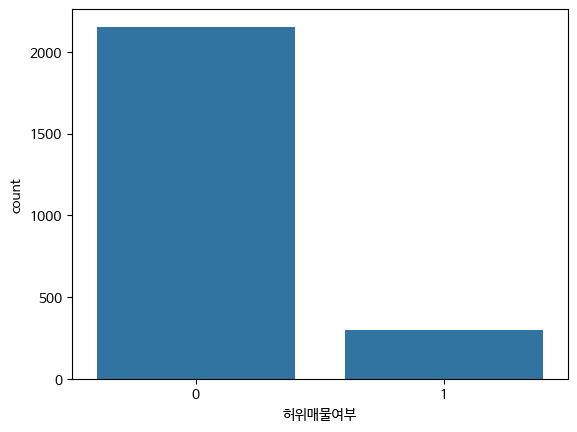

In [61]:
# 타겟 데이터(허위매물여부) 시각화

sns.countplot(x=target_column, data=df)

### 2-2 범주형 데이터

<ipython-input-44-fb043cb66f87>:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
<ipython-input-44-fb043cb66f87>:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
<ipython-input-44-fb043cb66f87>:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
<ipython-input-44-fb043cb66f87>:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
<ipython-input-44-fb043cb66f87>:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e.

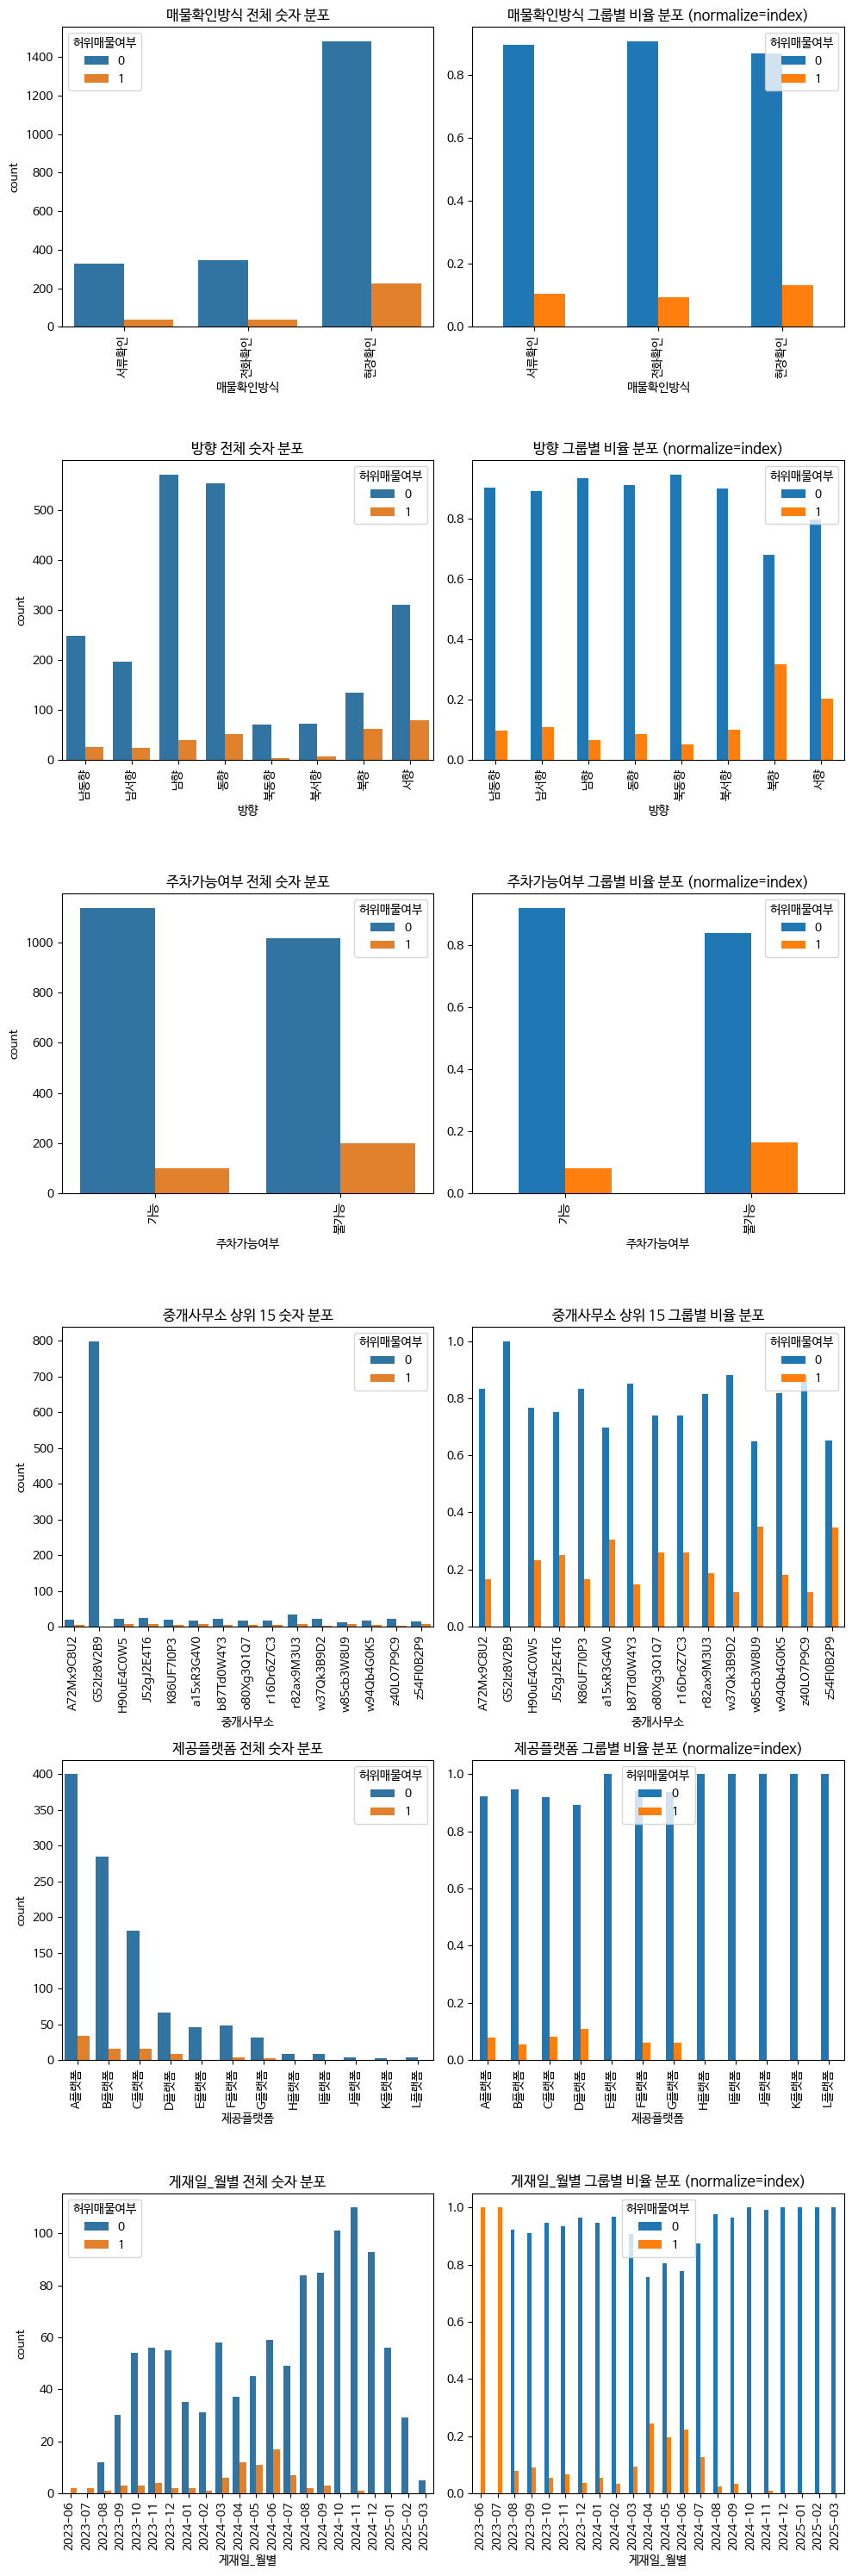

In [44]:
# categorical column 별 개수, 비율 분포 확인

fig, axes = plt.subplots(6, 2, figsize=(10, 30))

list_categorical_columns_repeat2 = []
for column in list_categorical_columns:
  list_categorical_columns_repeat2.append(column)
  list_categorical_columns_repeat2.append(column)

for index, value in enumerate(zip(list_categorical_columns_repeat2, axes.ravel())):
    column, ax = value

    # 게재일 예외처리: 월별로 집계하여 시각화
    if column == '게재일':
      column = '게재일_월별'
      df[column] = df['게재일'].str.slice(start=0, stop=-3) # 2024-11-12 -> 2024-11

    # 중개사무소 예외처리: 매물 개수가 많은 상위 15개만 시각화
    if column == '중개사무소':
      df_company = df.groupby('중개사무소').count()
      company_top_15 = df_company.sort_values(by='허위매물여부', ascending=False).head(15).index.tolist()
      df_company_top_15 = df[df['중개사무소'].isin(company_top_15)]
      df = df_company_top_15

    # 시각화 1열: 숫자 분포
    if index % 2 == 0:
      sns.countplot(
        data=df.sort_values(by=column),
        x=column,
        ax=ax,
        hue=target_column
      )

      if column == '중개사무소':
        ax.set_title(f"{column} 상위 15 숫자 분포")
      else:
        ax.set_title(f"{column} 전체 숫자 분포")

    # 시각화 2열: 각 그룹별 비율 분포
    elif index % 2 == 1:
      pd.crosstab(df[column], df[target_column], normalize='index').plot(kind="bar", ax=ax)
      if column == '중개사무소':
        ax.set_title(f"{column} 상위 15 그룹별 비율 분포")
      else:
        ax.set_title(f"{column} 그룹별 비율 분포 (normalize=index)")

    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()

### 2-3 숫자형 데이터

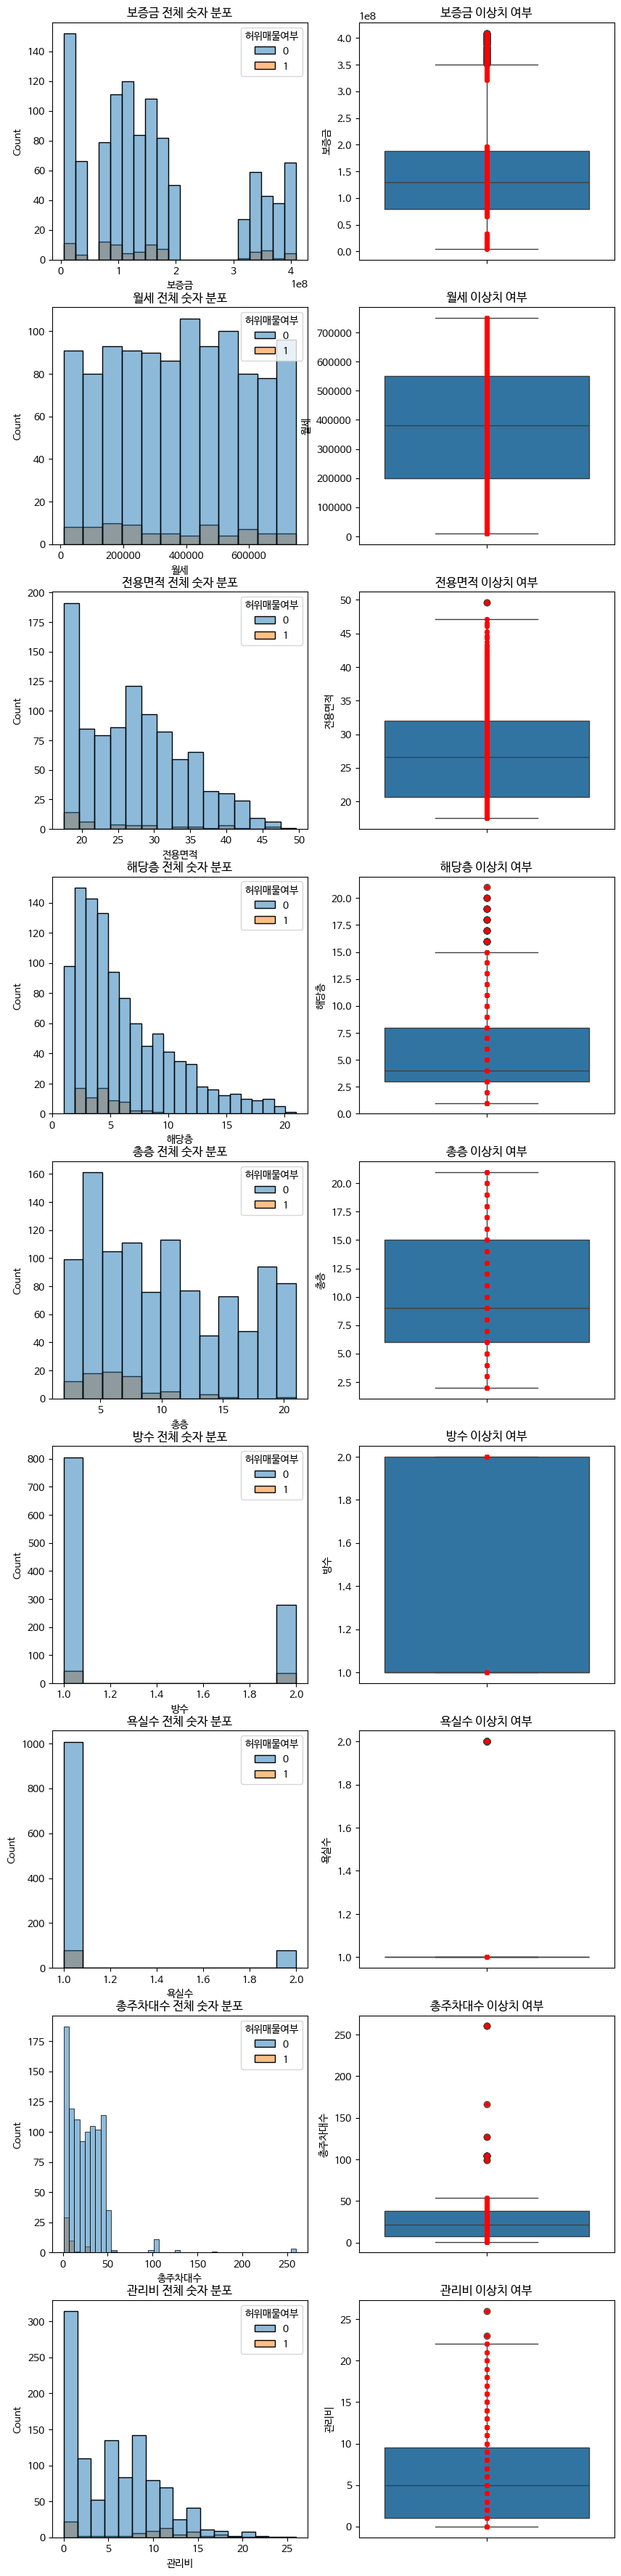

In [45]:
# numerical column 별 개수, 비율 분포 확인

fig, axes = plt.subplots(9,2, figsize=(10,45))

list_numerical_columns_repeat2 = []
for column in list_numerical_columns:
  list_numerical_columns_repeat2.append(column)
  list_numerical_columns_repeat2.append(column)

for index, value in enumerate(zip(list_numerical_columns_repeat2, axes.ravel())):
  column_name, ax = value

  # 좌측은 숫자 분포, 우측은 비율 분포
  if index % 2 == 0:
    sns.histplot(
        data=df,
        x=column_name,
        hue=target_column,
        ax=ax,
    )
    ax.set_title(f"{column_name} 전체 숫자 분포")

  elif index % 2 == 1:
    data = df[column_name]
    sns.boxplot(data=data, ax=ax)
    sns.stripplot(data=data, color="red", jitter=False, ax=ax)
    ax.set_title(f"{column_name} 이상치 여부")

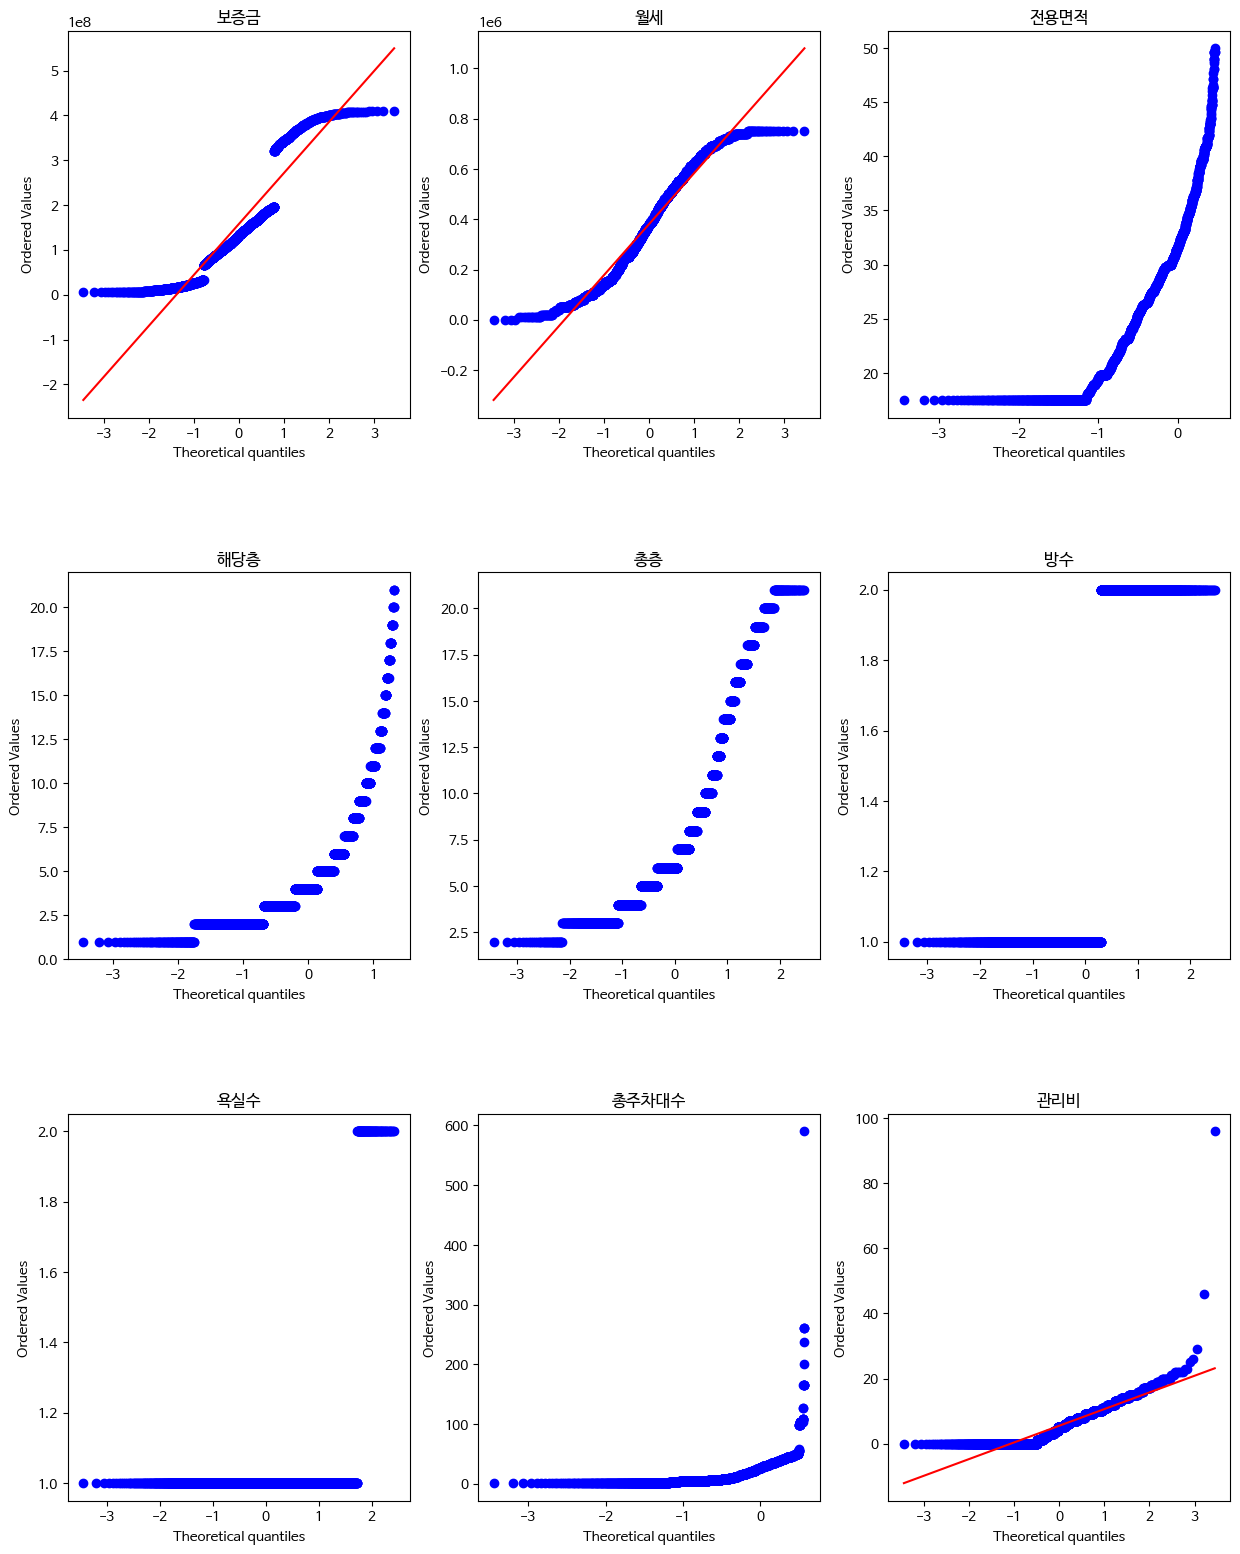

In [63]:
# numeric column 정규성 확인

plt.figure(figsize=(15,15))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4, wspace=0.2)
for column_name in list_numerical_columns:
    plt.subplot(3,3,x)
    x = x+1

    stats.probplot(df[column_name], dist=stats.norm, plot=plt)

    plt.title(column_name)
plt.show()

<Axes: >

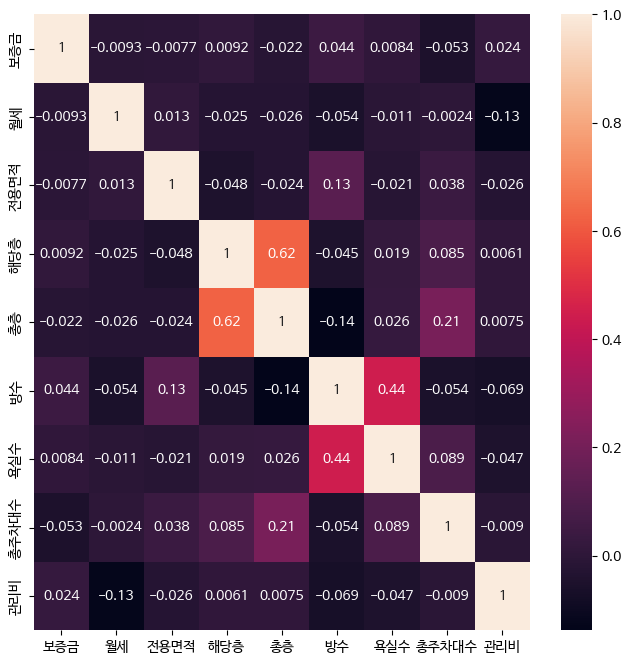

In [47]:
# numeric column 스피어만 상관계수 계산

df_corr = df[list_numerical_columns].corr(method="spearman")
plt.figure(figsize=(8, 8))
sns.heatmap(df_corr, annot=True)

In [49]:
# numeric column VIF 계산

# 숫자형 변수 선택
X = df.select_dtypes(include=["number"])

# 결측치(NaN) 평균으로 대체
X = X.fillna(X.median())

# VIF 계산
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# 결과 출력
vif_data

,Feature,VIF
0,보증금,2.661470
1,월세,3.881011
2,전용면적,11.514619
3,해당층,4.832696
4,총층,7.363514
5,방수,12.097449
6,욕실수,18.418262
7,총주차대수,2.357572
8,관리비,2.306582
9,허위매물여부,1.143145


### 2-4 결측 데이터

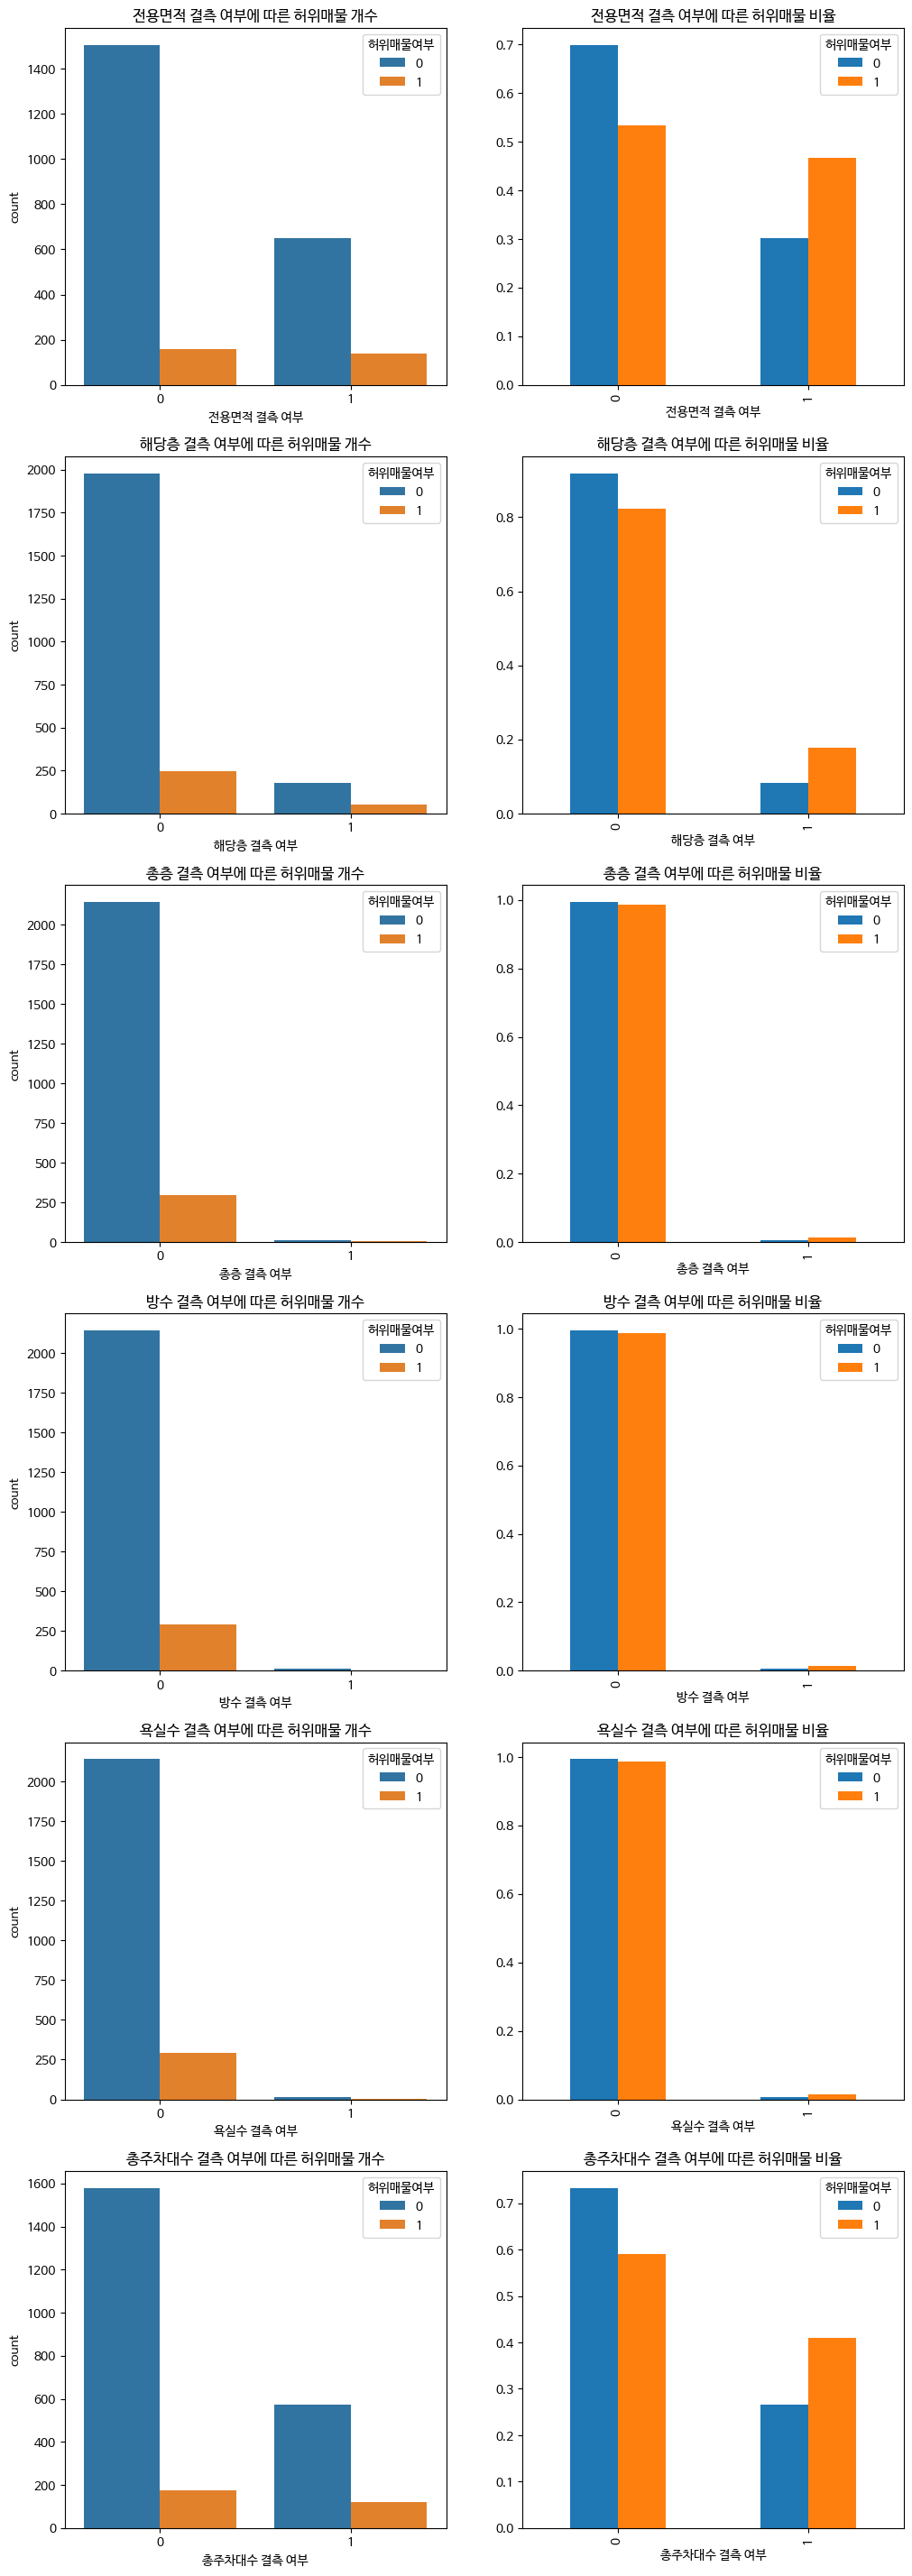

In [62]:
def set_isna(value):
  is_nan = math.isnan(float(value))

  if is_nan == True:
    return 1

  return 0

# 결측치가 있는 칼럼 목록
columns_with_missing = ['전용면적', '해당층', '총층', '방수', '욕실수', '총주차대수']
columns_with_missing_double = []
for column in columns_with_missing:
  columns_with_missing_double.append(column)
  columns_with_missing_double.append(column)

fig, axes = plt.subplots(6,2, figsize=(12,36))

for index, value in enumerate(zip(columns_with_missing_double, axes.ravel())):
    column_name, ax = value

    df[f'{column_name} 결측 여부'] = df[column_name].apply(set_isna)

    # 왼쪽은 숫자, 오른쪽은 비율
    if index % 2 == 0:
      sns.countplot(
        data=df,
        x=f'{column_name} 결측 여부',
        ax=ax,
        hue=target_column,
      ).set(title=f'{column_name} 결측 여부에 따른 허위매물 개수')
    else:
      data = pd.crosstab(df[f'{column_name} 결측 여부'], df[target_column], normalize='columns')
      data.plot(kind='bar', ax=ax).set(title=f'{column_name} 결측 여부에 따른 허위매물 비율')

## 3 데이터 전처리
- 회귀모델로 결측치 예측 후 대치

In [151]:
# 시작 시간 기록
start_time = time.time()

# 결측값이 있는 칼럼 리스트
missing_columns = ['전용면적', '총주차대수', '해당층', '욕실수', '총층', '방수']

# 평가 지표 저장용
results = {}

# 기본 RandomForestRegressor 모델 정의
rf = RandomForestRegressor(
    n_estimators=100,
    criterion='squared_error',
    max_depth=None,
    random_state=42
)

# 각 칼럼에 대해 결측값 대체
for column in missing_columns:
    print(f"ㅡㅡㅡㅡ{column} 결측치 대치중ㅡㅡㅡㅡ")
    print(df.isna().sum())

    # 결측값을 가진 데이터와 없는 데이터 분리
    X = df[list_numerical_columns].drop(columns=[column])
    y = df[column]

    # 대치할 칼럼 외 칼럼들의 결측값을 평균으로 대체
    fill_columns = missing_columns.copy()
    fill_columns.remove(column)
    for fill_column in fill_columns:
        X[fill_column] = SimpleImputer(strategy='mean').fit_transform(X[[fill_column]])

    # 결측값이 없는 데이터만 학습에 사용
    X_train = X[~y.isna()]
    y_train = y[~y.isna()]

    # 결측값이 있는 데이터만 예측에 사용
    X_test = X[y.isna()]

    # 모델 학습
    rf.fit(X_train, y_train)

    # 교차 검증 예측 값 얻기 (교차 검증은 X_train에 대해서만 예측)
    y_pred = cross_val_predict(rf, X_train, y_train, cv=3)

    # RMSE와 MAE 계산
    rmse = np.sqrt(mean_squared_error(y_train, y_pred))
    mae = mean_absolute_error(y_train, y_pred)

    # 결과 저장
    results[column] = {
        'rmse': rmse,
        'mae': mae,
        'model': rf
    }

    # 결측값 예측 (여기서 예측값을 채워야 함)
    y_pred_test = rf.predict(X_test)

    # 결측값 채우기
    df.loc[df[column].isnull(), column] = y_pred_test

# 결과 출력
print(f"ㅡㅡㅡㅡ결측치 대치 완료ㅡㅡㅡㅡ")
print(df.isna().sum())

# 끝 시간 기록
end_time = time.time()

# 학습 시간 계산
training_time = end_time - start_time
print(f"모델 학습 시간: {training_time:.2f} 초")

# 모델별 결과 요약을 DataFrame으로 변환
result_df = pd.DataFrame.from_dict(results, orient='index')
result_df = result_df[['rmse', 'mae']]

ㅡㅡㅡㅡ전용면적 결측치 대치중ㅡㅡㅡㅡ
매물확인방식      0
보증금         0
월세          0
전용면적      787
해당층       229
총층         16
방향          0
방수         16
욕실수        18
주차가능여부      0
총주차대수     696
관리비         0
중개사무소       0
제공플랫폼       0
게재일         0
허위매물여부      0
dtype: int64
ㅡㅡㅡㅡ총주차대수 결측치 대치중ㅡㅡㅡㅡ
매물확인방식      0
보증금         0
월세          0
전용면적        0
해당층       229
총층         16
방향          0
방수         16
욕실수        18
주차가능여부      0
총주차대수     696
관리비         0
중개사무소       0
제공플랫폼       0
게재일         0
허위매물여부      0
dtype: int64
ㅡㅡㅡㅡ해당층 결측치 대치중ㅡㅡㅡㅡ
매물확인방식      0
보증금         0
월세          0
전용면적        0
해당층       229
총층         16
방향          0
방수         16
욕실수        18
주차가능여부      0
총주차대수       0
관리비         0
중개사무소       0
제공플랫폼       0
게재일         0
허위매물여부      0
dtype: int64
ㅡㅡㅡㅡ욕실수 결측치 대치중ㅡㅡㅡㅡ
매물확인방식     0
보증금        0
월세         0
전용면적       0
해당층        0
총층        16
방향         0
방수        16
욕실수       18
주차가능여부     0
총주차대수      0
관리비        0
중개사무소      0
제공플랫폼      0
게재일        0
허위매물여부     

In [152]:
result_df_min = df[['전용면적', '총주차대수', '해당층', '욕실수', '총층', '방수']].min()
result_df_mean = df[['전용면적', '총주차대수', '해당층', '욕실수', '총층', '방수']].mean()
result_df_median = df[['전용면적', '총주차대수', '해당층', '욕실수', '총층', '방수']].median()
result_df_std = df[['전용면적', '총주차대수', '해당층', '욕실수', '총층', '방수']].std()
result_df_max = df[['전용면적', '총주차대수', '해당층', '욕실수', '총층', '방수']].max()
result_df_total = pd.concat([result_df_min, result_df_mean, result_df_median, result_df_std, result_df_max, result_df], axis=1)
result_df_total.columns = ['최소값', '평균값', '중앙값', '표준편차', '최대값','MRSE', 'MAE']

result_df_total

,최소값,평균값,중앙값,표준편차,최대값,MRSE,MAE
전용면적,17.5,27.661016,26.575,7.598453,49.97,7.008410,5.567027
총주차대수,1.0,16.957055,7.440,26.529787,590.00,23.110822,11.677323
해당층,1.0,4.909233,4.000,3.463096,21.00,2.569291,1.648115
욕실수,1.0,1.034258,1.000,0.181928,2.00,0.148497,0.041623
총층,2.0,8.050893,6.000,4.908684,21.00,3.192540,2.123030
방수,1.0,1.376032,1.000,0.484096,2.00,0.273923,0.157989


## 4 피쳐 엔지니어링
- 4-1 중개사무소
  - 중개사무소 클러스터링 후 빈도, 타겟 인코딩
- 4-2 게재일
  - 게재일 월별 변환 후 빈도, 타겟 인코딩

### 4-1 중개사무소

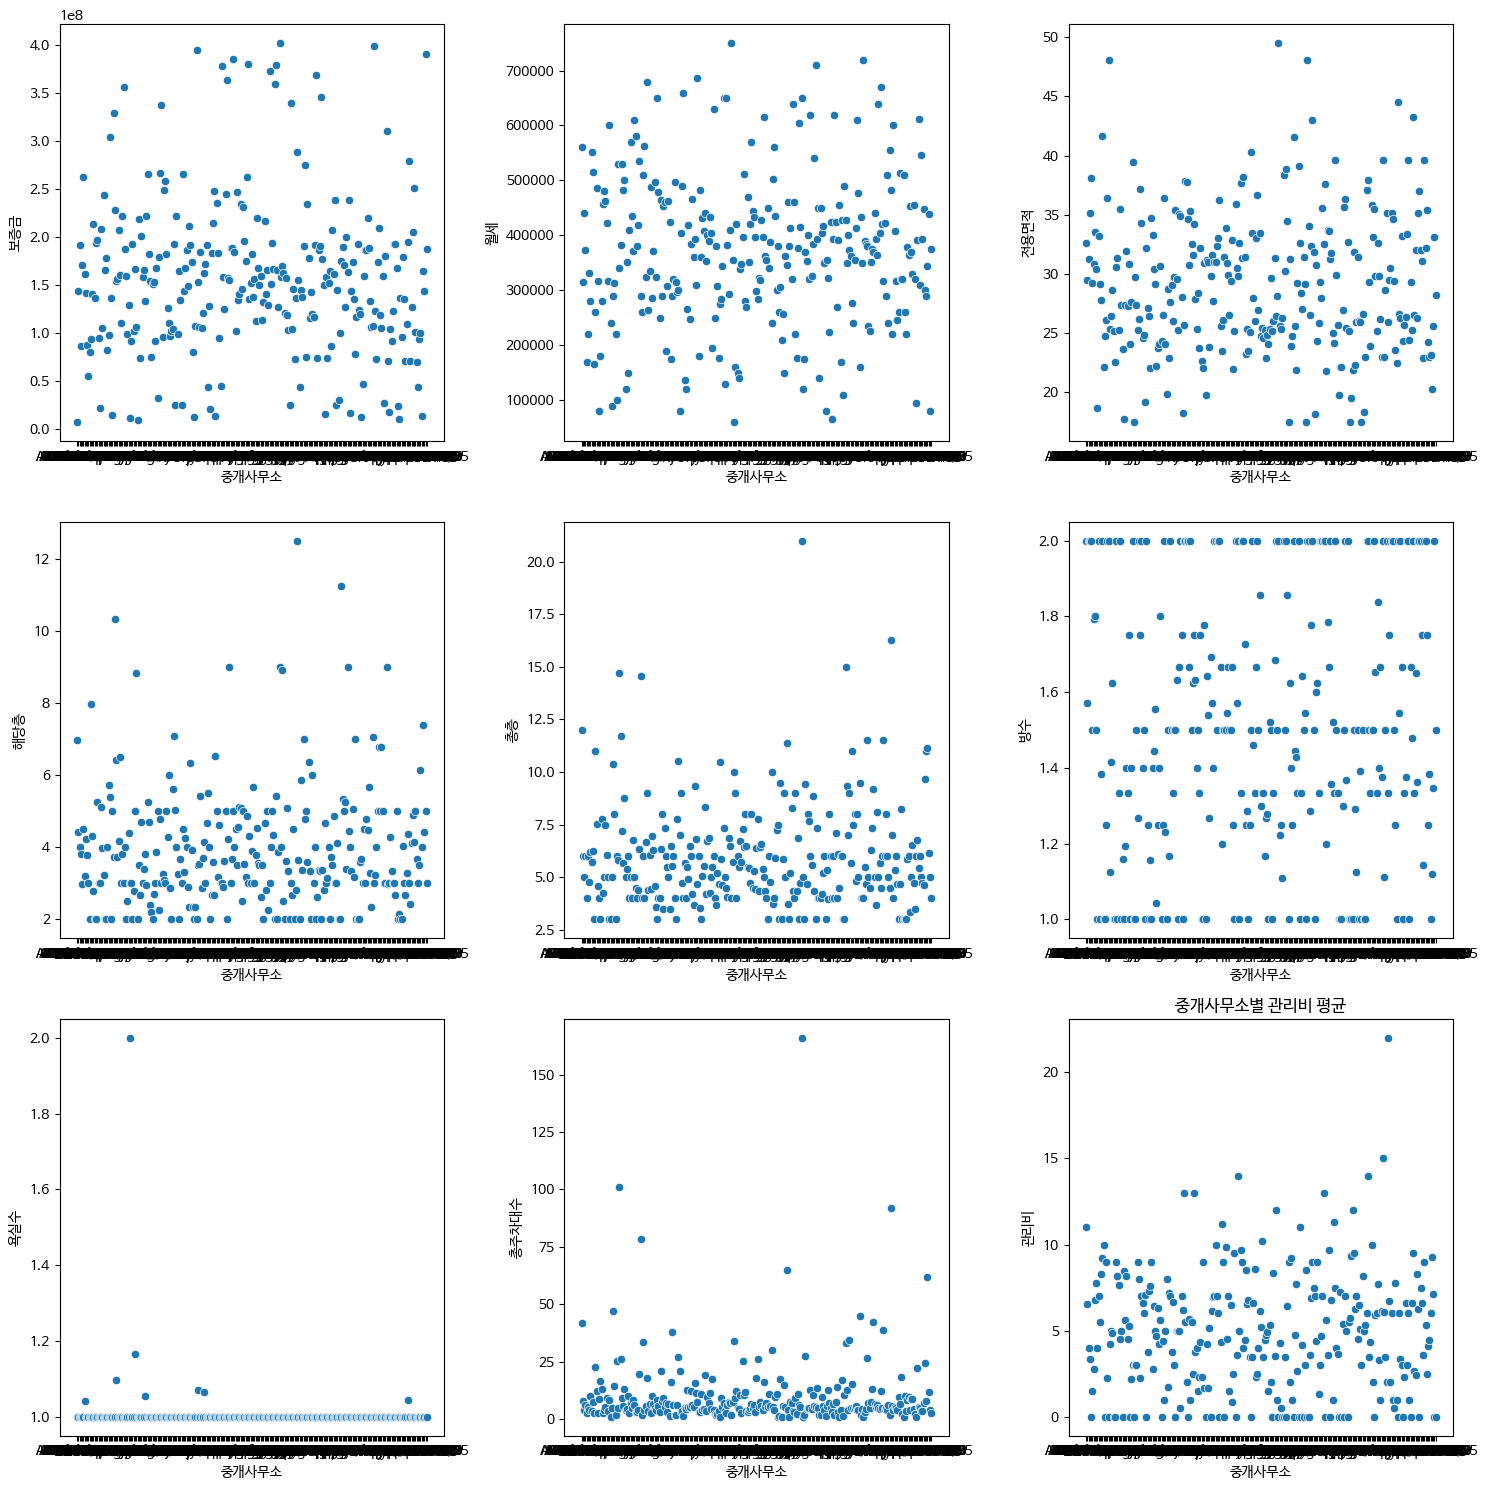

In [84]:
# 중개사무소별 숫자형 데이터 평균값 분포 확인

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for ax, column in zip(np.ravel(axes), list_numerical_columns):
  sns.scatterplot(df.groupby('중개사무소')[column].mean(), ax=ax)
  plt.xlabel('중개사무소')
  plt.ylabel(column)
  plt.title(f'중개사무소별 {column} 평균')

plt.tight_layout()
plt.show()

In [153]:
# 중개사무소별 집계 (허위매물 비율 포함)

office_stats = df.groupby('중개사무소').agg(
    허위매물_개수=('허위매물여부', 'sum'),
    총_매물수=('허위매물여부', 'count'),
    평균_보증금=('보증금', 'mean'),
    평균_월세=('월세', 'mean'),
    평균_전용면적=('전용면적', 'mean'),
    평균_층수=('해당층', 'mean'),
    평균_총층=('총층', 'mean'),
    평균_총주차대수=('총주차대수', 'mean'),
    평균_관리비=('관리비', 'mean'),
    평균_욕실수=('욕실수', 'mean'),
    평균_방수=('방수', 'mean'),
).reset_index()

# 허위매물 비율 추가
office_stats['허위매물_비율'] = office_stats['허위매물_개수'] / office_stats['총_매물수']

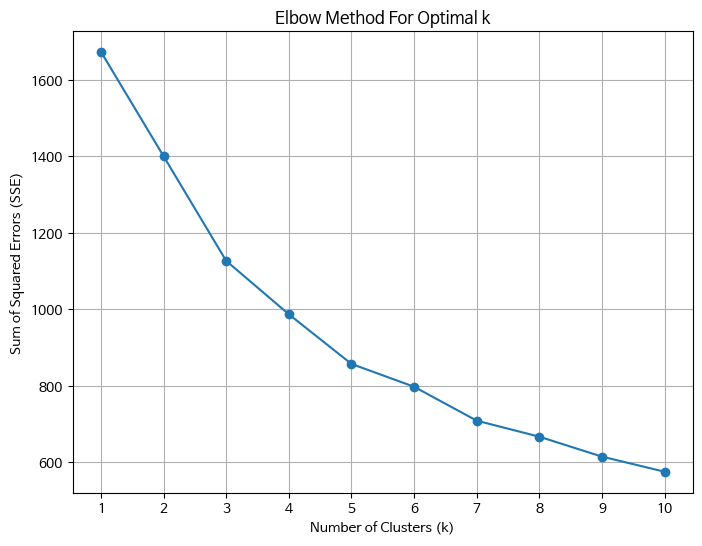

In [154]:
# 클러스터링을 위한 특징 선택
features = ['허위매물_비율', '총_매물수', '평균_보증금', '평균_월세', '평균_층수', '평균_관리비']

# 데이터 스케일링
scaler = StandardScaler()
scaled_features = scaler.fit_transform(office_stats[features])

# 클러스터 개수의 범위 설정
k_range = range(1, 11)

# SSE 값을 저장할 리스트
sse = []

# 다양한 k 값에 대해 KMeans 클러스터링 수행
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)  # 클러스터링의 합 내제곱 오차(SSE)

# 엘보우 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(k_range, sse, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.xticks(k_range)
plt.grid(True)
plt.show()


In [155]:
# KMeans 클러스터링 적용
kmeans = KMeans(n_clusters=3, random_state=42)
office_stats['중개사무소_cluster'] = kmeans.fit_predict(scaled_features)

# 원본 데이터에 클러스터 정보 병합
df = df.merge(office_stats[['중개사무소', '중개사무소_cluster']], on='중개사무소', how='left')

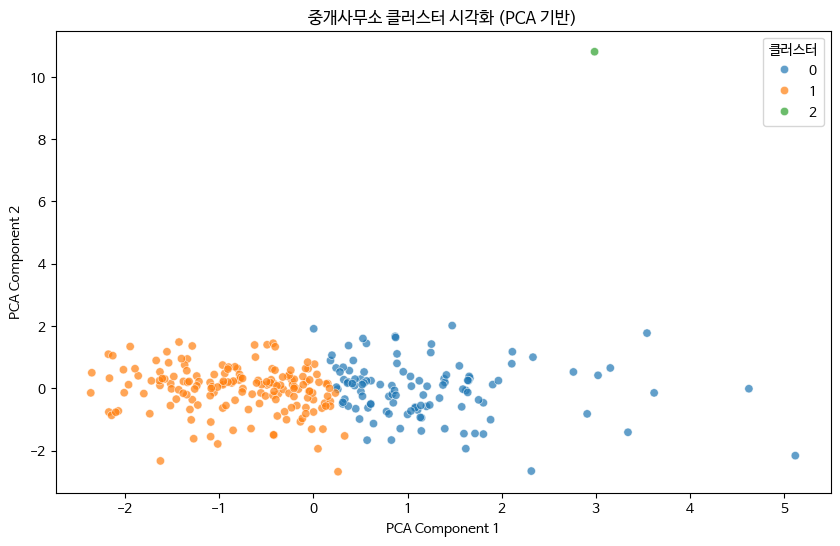

In [95]:
# PCA를 이용한 차원 축소 (2차원)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# 결과를 데이터프레임에 추가
office_stats['PCA1'] = pca_result[:, 0]
office_stats['PCA2'] = pca_result[:, 1]

# 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1',
    y='PCA2',
    hue='중개사무소_cluster',
    palette='tab10',
    data=office_stats,
    alpha=0.7
)
plt.title("중개사무소 클러스터 시각화 (PCA 기반)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="클러스터")
plt.show()


<Axes: xlabel='중개사무소_cluster', ylabel='count'>

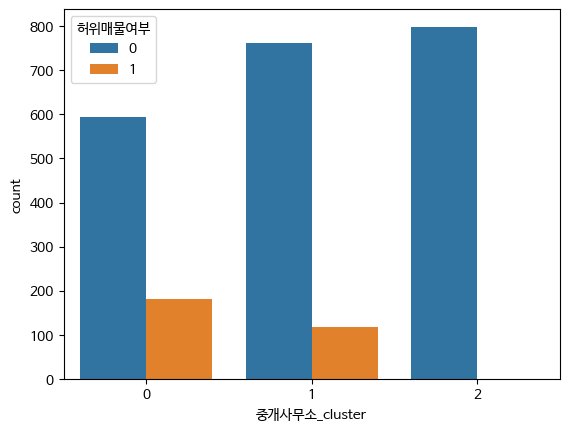

In [96]:
sns.countplot(x='중개사무소_cluster', hue='허위매물여부', data=df)

Text(0, 0.5, '중개사무소 unique 개수')

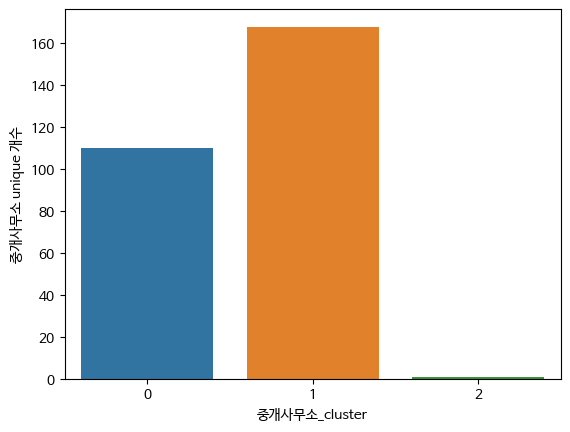

In [97]:
cluster_unique_counts = {}

for i in range(0,3):
  cluster_unique_counts[i] = len(df[df["중개사무소_cluster"]==i]["중개사무소"].unique())

df_cluster_unique_counts = pd.DataFrame(cluster_unique_counts, index=['count'])
sns.barplot(data=df_cluster_unique_counts)

plt.xlabel('중개사무소_cluster')
plt.ylabel('중개사무소 unique 개수')

In [156]:
# 클러스터별 허위매물 비율 평균
cluster_stats = df.groupby('중개사무소_cluster')[target_column].agg(['mean', 'count']).reset_index()
cluster_stats.columns = ['중개사무소_cluster', '중개사무소_cluster_fraud_rate', '중개사무소_cluster_size']

# 원본 데이터에 추가
df = df.merge(cluster_stats, on='중개사무소_cluster', how='left')

df.head()

,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,게재일,허위매물여부,중개사무소_cluster,중개사무소_cluster_fraud_rate,중개사무소_cluster_size
0,현장확인,402500000.0,470000,24.8962,7.17,15.0,서향,1.0,1.0,가능,40.00,96,t93Nt6I2I0,B플랫폼,2024-10-09,0,0,0.233850,774
1,현장확인,170500000.0,200000,40.2486,3.00,4.0,남동향,2.0,1.0,불가능,2.37,0,q39iV5J4E6,D플랫폼,2024-12-26,0,1,0.133106,879
2,전화확인,114000000.0,380000,25.0873,2.00,3.0,동향,1.0,1.0,불가능,7.84,0,b03oE4G3F6,A플랫폼,2024-11-28,0,1,0.133106,879
3,현장확인,163500000.0,30000,36.3000,3.00,9.0,남동향,2.0,1.0,가능,13.00,10,G52Iz8V2B9,A플랫폼,2024-11-26,0,2,0.000000,799
4,현장확인,346000000.0,530000,34.7856,3.00,3.0,동향,2.0,1.0,불가능,2.73,0,N45gM0M7R0,B플랫폼,2024-06-25,1,1,0.133106,879


### 4-2 게재일

In [157]:
df['게재일'] = pd.to_datetime(df['게재일'])
df['게재일'] = df['게재일'].dt.strftime('%Y%m')

<ipython-input-158-51ca5ba72f23>:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
<ipython-input-158-51ca5ba72f23>:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


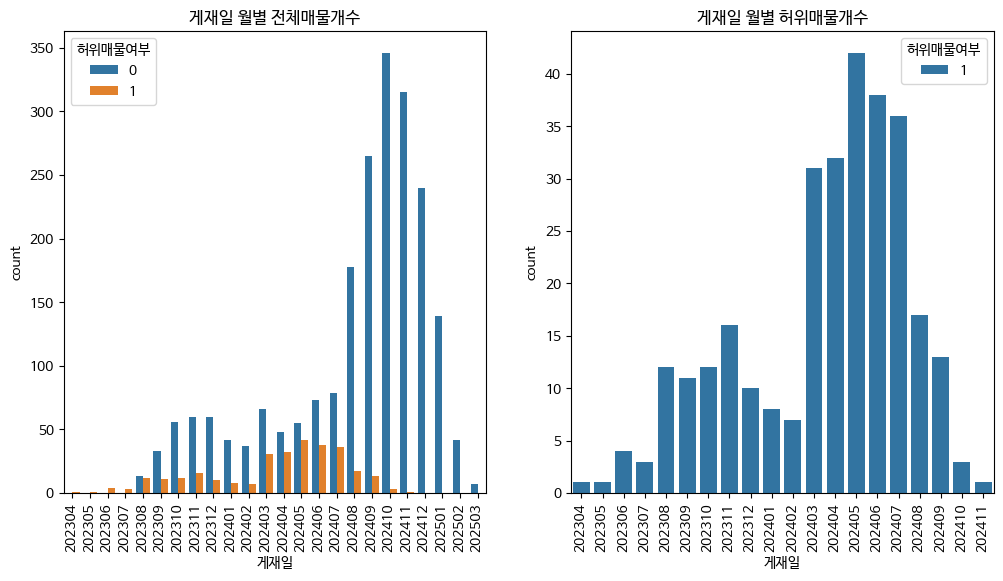

In [158]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

list_date = ['게재일', '게재일']

for index, value in enumerate(zip(np.ravel(axes), list_date)):
  ax, column = value

  if index == 0:
    sns.countplot(data=df.sort_values('게재일'), x='게재일', hue=target_column, ax=ax)
    ax.set_title('게재일 월별 전체매물개수')

  else:
    sns.countplot(data=df[df['허위매물여부'] == 1].sort_values('게재일'), x='게재일', hue=target_column, ax=ax)
    ax.set_title('게재일 월별 허위매물개수')

  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.show()

In [159]:
# 게재일 월별 허위매물 비율 평균
cluster_stats = df.groupby('게재일')[target_column].agg(['mean', 'count']).reset_index()
cluster_stats.columns = ['게재일', '게재일_fraud_rate', '게재일_size']

# 원본 데이터에 추가
df = df.merge(cluster_stats, on='게재일', how='left')

df.head(3)

,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,...,관리비,중개사무소,제공플랫폼,게재일,허위매물여부,중개사무소_cluster,중개사무소_cluster_fraud_rate,중개사무소_cluster_size,게재일_fraud_rate,게재일_size
0,현장확인,402500000.0,470000,24.8962,7.17,15.0,서향,1.0,1.0,가능,...,96,t93Nt6I2I0,B플랫폼,202410,0,0,0.233850,774,0.008596,349
1,현장확인,170500000.0,200000,40.2486,3.00,4.0,남동향,2.0,1.0,불가능,...,0,q39iV5J4E6,D플랫폼,202412,0,1,0.133106,879,0.000000,240
2,전화확인,114000000.0,380000,25.0873,2.00,3.0,동향,1.0,1.0,불가능,...,0,b03oE4G3F6,A플랫폼,202411,0,1,0.133106,879,0.003165,316


### 4-3 나머지 범주형 피쳐

In [172]:
# Label Encoding 적용 열
label_encode_cols = ['게재일','제공플랫폼','방향', '주차가능여부', '매물확인방식']

label_encoders = {}
for col in label_encode_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

df.head()

,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,...,관리비,중개사무소,제공플랫폼,게재일,허위매물여부,중개사무소_cluster,중개사무소_cluster_fraud_rate,중개사무소_cluster_size,게재일_fraud_rate,게재일_size
0,2,402500000.0,470000,24.8962,7.17,15.0,7,1.0,1.0,0,...,96,t93Nt6I2I0,1,18,0,0,0.233850,774,0.008596,349
1,2,170500000.0,200000,40.2486,3.00,4.0,0,2.0,1.0,1,...,0,q39iV5J4E6,3,20,0,1,0.133106,879,0.000000,240
2,1,114000000.0,380000,25.0873,2.00,3.0,3,1.0,1.0,1,...,0,b03oE4G3F6,0,19,0,1,0.133106,879,0.003165,316
3,2,163500000.0,30000,36.3000,3.00,9.0,0,2.0,1.0,0,...,10,G52Iz8V2B9,0,19,0,2,0.000000,799,0.003165,316
4,2,346000000.0,530000,34.7856,3.00,3.0,3,2.0,1.0,1,...,0,N45gM0M7R0,1,14,1,1,0.133106,879,0.342342,111


In [173]:
df.drop(columns=['중개사무소'], inplace=True)

### 4-4 테스트 데이터 동일 적용

In [160]:
df_test = pd.read_csv('/content/drive/MyDrive/MLOps_스터디/test.csv')

In [161]:
# 시작 시간 기록
start_time = time.time()

# 결측값이 있는 칼럼 리스트
missing_columns = ['전용면적', '총주차대수', '해당층', '욕실수', '총층', '방수']

# 평가 지표 저장용
results = {}

# 기본 RandomForestRegressor 모델 정의
rf = RandomForestRegressor(
    n_estimators=100,
    criterion='squared_error',
    max_depth=None,
    random_state=42
)

# 각 칼럼에 대해 결측값 대체
for column in missing_columns:
    print(f"ㅡㅡㅡㅡ{column} 결측치 대치중ㅡㅡㅡㅡ")
    print(df_test.isna().sum())

    # 결측값을 가진 데이터와 없는 데이터 분리
    X = df_test[list_numerical_columns].drop(columns=[column])
    y = df_test[column]

    # 대치할 칼럼 외 칼럼들의 결측값을 평균으로 대체
    fill_columns = missing_columns.copy()
    fill_columns.remove(column)
    for fill_column in fill_columns:
        X[fill_column] = SimpleImputer(strategy='mean').fit_transform(X[[fill_column]])

    # 결측값이 없는 데이터만 학습에 사용
    X_train = X[~y.isna()]
    y_train = y[~y.isna()]

    # 결측값이 있는 데이터만 예측에 사용
    X_test = X[y.isna()]

    # 모델 학습
    rf.fit(X_train, y_train)

    # 교차 검증 예측 값 얻기 (교차 검증은 X_train에 대해서만 예측)
    y_pred = cross_val_predict(rf, X_train, y_train, cv=3)

    # RMSE와 MAE 계산
    rmse = np.sqrt(mean_squared_error(y_train, y_pred))
    mae = mean_absolute_error(y_train, y_pred)

    # 결과 저장
    results[column] = {
        'rmse': rmse,
        'mae': mae,
        'model': rf
    }

    # 결측값 예측 (여기서 예측값을 채워야 함)
    y_pred_test = rf.predict(X_test)

    # 결측값 채우기
    df_test.loc[df_test[column].isnull(), column] = y_pred_test

# 결과 출력
print(f"ㅡㅡㅡㅡ결측치 대치 완료ㅡㅡㅡㅡ")
print(df_test.isna().sum())

# 끝 시간 기록
end_time = time.time()

# 학습 시간 계산
training_time = end_time - start_time
print(f"모델 학습 시간: {training_time:.2f} 초")

# 모델별 결과 요약을 DataFrame으로 변환
result_df_test = pd.DataFrame.from_dict(results, orient='index')
result_df_test = result_df_test[['rmse', 'mae']]

ㅡㅡㅡㅡ전용면적 결측치 대치중ㅡㅡㅡㅡ
ID          0
매물확인방식      0
보증금         0
월세          0
전용면적      184
해당층        50
총층          2
방향          0
방수          2
욕실수         2
주차가능여부      0
총주차대수     175
관리비         0
중개사무소       0
제공플랫폼       0
게재일         0
dtype: int64
ㅡㅡㅡㅡ총주차대수 결측치 대치중ㅡㅡㅡㅡ
ID          0
매물확인방식      0
보증금         0
월세          0
전용면적        0
해당층        50
총층          2
방향          0
방수          2
욕실수         2
주차가능여부      0
총주차대수     175
관리비         0
중개사무소       0
제공플랫폼       0
게재일         0
dtype: int64
ㅡㅡㅡㅡ해당층 결측치 대치중ㅡㅡㅡㅡ
ID         0
매물확인방식     0
보증금        0
월세         0
전용면적       0
해당층       50
총층         2
방향         0
방수         2
욕실수        2
주차가능여부     0
총주차대수      0
관리비        0
중개사무소      0
제공플랫폼      0
게재일        0
dtype: int64
ㅡㅡㅡㅡ욕실수 결측치 대치중ㅡㅡㅡㅡ
ID        0
매물확인방식    0
보증금       0
월세        0
전용면적      0
해당층       0
총층        2
방향        0
방수        2
욕실수       2
주차가능여부    0
총주차대수     0
관리비       0
중개사무소     0
제공플랫폼     0
게재일       0
dtype: int64
ㅡㅡㅡㅡ총층 결측치 대치중ㅡㅡㅡ

In [162]:
result_df_min = df_test[['전용면적', '총주차대수', '해당층', '욕실수', '총층', '방수']].min()
result_df_mean = df_test[['전용면적', '총주차대수', '해당층', '욕실수', '총층', '방수']].mean()
result_df_median = df_test[['전용면적', '총주차대수', '해당층', '욕실수', '총층', '방수']].median()
result_df_std = df_test[['전용면적', '총주차대수', '해당층', '욕실수', '총층', '방수']].std()
result_df_max = df_test[['전용면적', '총주차대수', '해당층', '욕실수', '총층', '방수']].max()
result_df_total = pd.concat([result_df_min, result_df_mean, result_df_median, result_df_std, result_df_max, result_df], axis=1)
result_df_total.columns = ['최소값', '평균값', '중앙값', '표준편차', '최대값','MRSE', 'MAE']

result_df_total

,최소값,평균값,중앙값,표준편차,최대값,MRSE,MAE
전용면적,17.5,28.347207,27.63,7.540850,49.97,7.008410,5.567027
총주차대수,1.0,17.012692,9.00,20.199419,169.00,23.110822,11.677323
해당층,1.0,4.553703,4.00,3.285734,21.00,2.569291,1.648115
욕실수,1.0,1.034339,1.00,0.182035,2.00,0.148497,0.041623
총층,2.0,7.692871,6.00,4.635726,21.00,3.192540,2.123030
방수,1.0,1.400082,1.00,0.489960,2.00,0.273923,0.157989


In [163]:
df_test['게재일'] = pd.to_datetime(df_test['게재일'])
df_test['게재일'] = df_test['게재일'].dt.strftime('%Y%m')

In [164]:
def apply_cluster(value, column, col):
    df_tmp = df[df[column] == value]

    if df_tmp.empty:
        return -1  # 조건에 맞는 데이터가 없으면 -1 반환

    return df_tmp.iloc[0][col]

encode_columns = ['중개사무소', '게재일']

for column in encode_columns:
  if column == '중개사무소':
    columns = [f'{column}_cluster' ,f'{column}_cluster_fraud_rate', f'{column}_cluster_size']

  if column == '게재일':
    columns = ['게재일_fraud_rate', '게재일_size']

  for col in columns:
      df_test[col] = df_test[column].apply(lambda x: apply_cluster(x, column, col))

In [168]:
# 미분류된 중개사무소 클러스터 적용

from sklearn.metrics.pairwise import euclidean_distances

# 훈련 데이터에서 클러스터 중심 계산 (허위매물비율 포함)
cluster_centers = kmeans.cluster_centers_

def apply_office_cluster(row):
  if row['중개사무소_cluster'] != -1:
    return row['중개사무소_cluster']

  no_office_stats = df_test[df_test['중개사무소'] == row['중개사무소']].groupby('중개사무소').agg(
      총_매물수=('보증금', 'count'),
      평균_보증금=('보증금', 'mean'),
      평균_월세=('월세', 'mean'),
      평균_전용면적=('전용면적', 'mean'),
      평균_층수=('해당층', 'mean'),
      평균_총층=('총층', 'mean'),
      평균_총주차대수=('총주차대수', 'mean'),
      평균_관리비=('관리비', 'mean'),
      평균_욕실수=('욕실수', 'mean'),
      평균_방수=('방수', 'mean'),
      허위매물_비율=('게재일_fraud_rate', 'mean')
  ).reset_index()

  # 허위매물여부가 없어서 허위매물비율을 계산할 수 없다면, 그 값은 0으로 처리

  # 훈련 데이터에서 사용한 모든 특징을 포함
  features_with_fraud = no_office_stats[['허위매물_비율', '총_매물수', '평균_보증금', '평균_월세', '평균_층수', '평균_관리비']].values

  # 각 클러스터 중심과의 거리 계산
  distances = euclidean_distances(features_with_fraud, cluster_centers)

  # 가장 가까운 클러스터 선택 (test 중개사무소가 훈련 데이터에 없으므로, 가장 가까운 클러스터를 선택)
  closest_cluster = np.argmin(distances, axis=1)

  # 가장 가까운 클러스터 번호 출력
  return closest_cluster[0]

df_test['중개사무소_cluster'] = df_test.apply(apply_office_cluster, axis=1)

In [169]:
# 미분류된 중개사무소 클러스터 사이즈 적용

def apply_office_size(row):
  if row['중개사무소_cluster_size'] == -1:
    cluster_size = df[df['중개사무소_cluster'] == row['중개사무소_cluster']].loc[0, '중개사무소_cluster_size']
    return cluster_size
  else:
    return row['중개사무소_cluster_size']

df_test['중개사무소_cluster_size'] = df_test.apply(apply_office_size, axis=1)

In [170]:
# 미분류된 중개사무소 클러스터 허위매물비율 적용

def apply_office_fraud_rate(row):
  if row['중개사무소_cluster_fraud_rate'] == -1:
    cluster_fraud_rate = df[df['중개사무소_cluster'] == row['중개사무소_cluster']].loc[0, '중개사무소_cluster_fraud_rate']
    return cluster_fraud_rate
  else:
    return row['중개사무소_cluster_fraud_rate']

df_test['중개사무소_cluster_fraud_rate'] = df_test.apply(apply_office_fraud_rate, axis=1)

In [171]:
# Label Encoding 적용 열
label_encode_cols = ['게재일','제공플랫폼','방향', '주차가능여부', '매물확인방식']

label_encoders = {}
for col in label_encode_cols:
    le = LabelEncoder()
    df_test[col] = le.fit_transform(df_test[col].astype(str))
    label_encoders[col] = le

df_test.head()

,ID,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,...,총주차대수,관리비,중개사무소,제공플랫폼,게재일,중개사무소_cluster,중개사무소_cluster_fraud_rate,중개사무소_cluster_size,게재일_fraud_rate,게재일_size
0,TEST_000,0,223000000.0,530000,21.9573,5.0,5.0,2,1.0,1.0,...,7.99,7,Z86Th6S3K5,3,16,1,0.133106,879,0.008596,349
1,TEST_001,0,150500000.0,590000,30.2600,7.0,11.0,7,1.0,1.0,...,16.00,11,G52Iz8V2B9,3,3,2,0.000000,799,0.250000,44
2,TEST_002,2,47000000.0,200000,41.5000,2.0,3.0,1,2.0,1.0,...,5.22,0,N45gM0M7R0,1,10,1,0.133106,879,0.400000,80
3,TEST_003,0,133000000.0,250000,31.3500,5.0,6.0,2,2.0,1.0,...,5.33,5,C41wx1K6U9,1,15,0,0.233850,774,0.046763,278
4,TEST_004,2,108000000.0,380000,23.1400,2.0,3.0,2,1.0,1.0,...,9.22,0,Z68ZJ6F6L4,0,17,1,0.133106,879,0.003165,316


In [179]:
df_test.drop(columns=['ID', '중개사무소'], inplace=True)

## 5 모델 엔지니어링
- 5-1 모델 학습
- 5-2 모델 평가
- 5-3 모델 해석
- 5-4 모델 예측

### 5-1 모델 학습

In [174]:
Y = df[target_column]
X = df.drop([target_column], axis=1)

# 랜덤 포레스트 모델 설정
best_model = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    max_depth=None,
    random_state=42,
)

best_model.fit(X, Y)

RandomForestClassifier(random_state=42)

### 5-2 모델 평가

In [175]:
"""
모델 평가 지표 확인
- 교차검증
- f1-macro
"""

# Stratified K-Fold 설정
# 데이터를 5개 폴드로 나눔 (Stratified 방식으로 클래스 비율 유지)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 교차 검증 수행
# 5번의 반복 학습 & 평가 수행
cv_scores = cross_val_score(best_model, X, Y, cv=cv, scoring='f1_macro')

# 결과 출력
# 각 폴드에서 나온 평가 점수(정확도 등)를 평균 내어 최종 성능을 결정
print(f'교차 검증 f1_macro: {cv_scores}')
print(f'평균 f1_macro: {cv_scores.mean():.4f}')

# 교차 검증 예측 수행
y_pred = cross_val_predict(best_model, X, Y, cv=cv)

# 평가 결과 출력
print("Classification Report:")
print(classification_report(Y, y_pred))


교차 검증 f1_macro: [0.91628303 0.91068397 0.92714026 0.87300304 0.91199713]
평균 f1_macro: 0.9078
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2154
           1       0.86      0.82      0.84       298

    accuracy                           0.96      2452
   macro avg       0.92      0.90      0.91      2452
weighted avg       0.96      0.96      0.96      2452



### 5-3 모델 해석

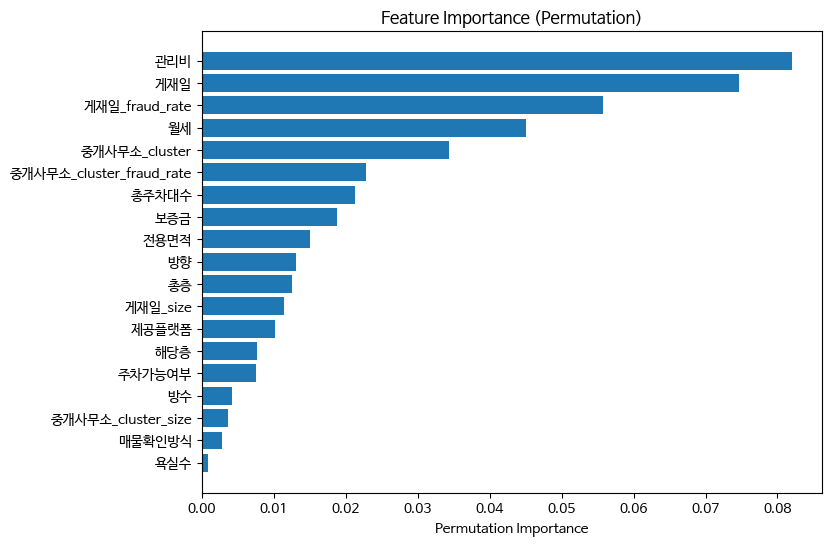

In [176]:
"""
Permutation Importance (Feature Importance by Shuffling)

[개념]
- 모델의 특정 특성(Feature) 을 랜덤하게 섞어서(Shuffle) 성능(F1, Accuracy 등)이 얼마나 감소하는지를 측정하는 방법
- 특정 특성이 중요하다면, 해당 특성을 랜덤하게 섞으면 모델 성능이 크게 하락
- 특정 특성이 덜 중요하다면, 랜덤하게 섞어도 성능이 거의 변하지 않음

[계산 방법]
- 원래 데이터로 모델 성능(기준 성능) 을 측정
- 한 개의 특성을 랜덤하게 섞고 모델 성능을 다시 측정
- 성능 감소량(기준 성능 - 섞은 후 성능)을 특성 중요도로 설정
- 위 과정을 모든 특성에 대해 반복
"""

from sklearn.inspection import permutation_importance

# Permutation Importance 계산
perm_importance = permutation_importance(best_model, X, Y, scoring="f1_macro", n_repeats=10, random_state=42)

# 결과 시각화
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(8, 6))
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance (Permutation)")
plt.show()


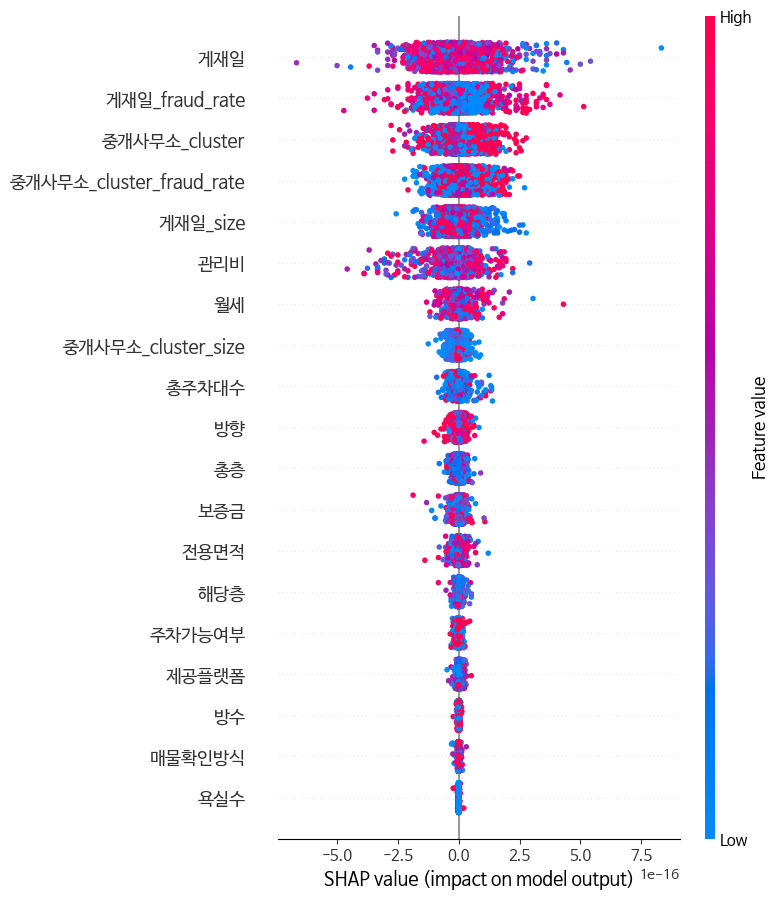

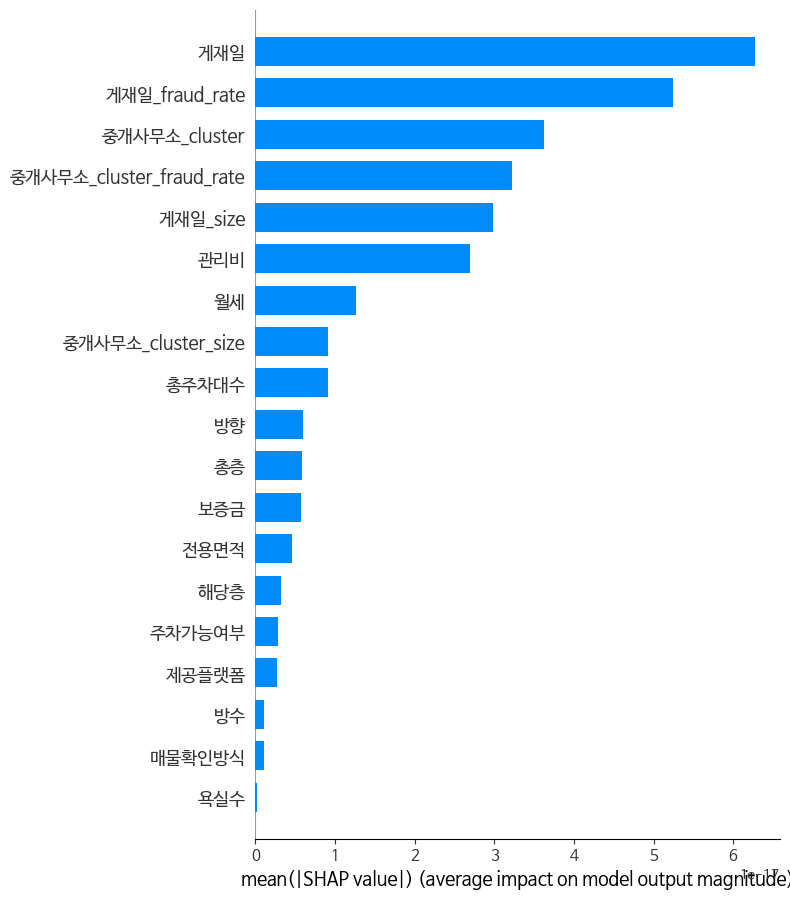

In [177]:
"""
SHAP Value (Shapley Additive Explanations)

[개념]
- 게임 이론(Game Theory)의 Shapley Value를 기반으로, 각 특성이 예측값에 기여한 정도를 계산
- 특정 샘플이 예측 결과를 만들기 위해 개별 특성이 얼마나 기여했는지를 확인 가능
- 특성별 기여도(양수/음수)를 개별 샘플 단위로 측정 가능

[계산 방법]
- 모든 특성 조합을 만들어 각각의 조합에서 예측값을 계산
- 특정 특성을 추가했을 때 예측값이 얼마나 변하는지를 측정하여 기여도를 계산
- 모든 조합을 고려하여 각 특성의 평균적인 기여도(SHAP Value) 를 계산
"""

import shap

# SHAP Explainer 생성
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X)

# RandomForest는 클래스별 평균을 구해서 2차원으로 변환
shap_values_mean = shap_values.mean(axis=2)  # (491, 16, 2) -> (491, 16)

# SHAP Summary Plot
shap.summary_plot(shap_values_mean, X)
shap.summary_plot(shap_values_mean, X, plot_type='bar')

### 5-4 모델 예측

In [180]:
# 제출

pred = pd.Series(best_model.predict(df_test))
pred

submit = pd.read_csv('/content/drive/MyDrive/MLOps_스터디/sample_submission.csv')
submit['허위매물여부'] = pred
submit.head()

submit.to_csv('submission.csv',index=False)

submit

,ID,허위매물여부
0,TEST_000,0
1,TEST_001,0
2,TEST_002,1
3,TEST_003,0
4,TEST_004,0
...,...,...
608,TEST_608,0
609,TEST_609,0
610,TEST_610,0
611,TEST_611,0
